# Python_XML_TFM
##### Author: "Gustavo E. Salado Carrera"
##### Email: gsaladocarr@alumni.unav.es



## **Instalar Librerías**
Se instalan las siguientes liberías para:
* _biopython_: acceder a bases de datos biológicas NCBI
* _geopandas_: trazar mapas y gráficos georeferenciados
* _xmltodict_: transformar nodos XML a objetos tipo diccionario
* _colab.drive_: guardar datos en la nube

In [ ]:
# Correr en Google colab, instalar biopython
try:
    import google.colab
    %pip install biopython
    %pip install xmltodict
    %pip install geopandas
except ImportError:
    pass

# Conectar a One drive
print('')
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    COLAB = True
    print("Connected to Drive")
    %tensorflow_version 2.x
except:
    print("No connected to Drive")
    COLAB = False    

# Importar librerias
%reset -f
import matplotlib.pyplot as plt
import geopandas as gpd
from google.colab import data_table
from Bio import SeqIO, SearchIO, Entrez
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 16.7 MB 464 kB/s 
     |████████████████████████████████| 6.3 MB 47.7 MB/s 

Mounted at /content/drive
Connected to Drive
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## **Function *researcher***
Esta función descarga información sobre organismos desde una base de datos especificada; y filtra esta información para los países indicados.

Parámetros:
* _Species_: Vector con el nombre de los organismos
* _db_: Nombre de la base de datos NCBI
* _Countries_: Vector con el nombre de los países

Resultado:
* Dataframe con la información de los organismos filtrada según los países especificados.

In [ ]:
def researcher(Species, db, Countries):

  # Lista de especies
  Species = [item + '[Orgn]' for item in Species]
  term = ' OR '.join(Species)

  # Contar IDs
  handle = Entrez.esearch(db = db, term = term)
  search = Entrez.read(handle)
  count = search['Count']
  print('Descargando:', count, 'IDs')

  # Get full IDs list using getted count
  handle = Entrez.esearch(db = db, term = term, retmax = count)
  search = Entrez.read(handle)
  idList = search["IdList"]
  #print(idList, '\n')

  # Definir dataframe
  df = pd.DataFrame(index = idList,
                columns=['organism', 'accesion', 'version', 'country',
                        'lat_lon', 'gene', 'protein_id', 'moltype', 
                        'length', 'organelle', 'taxonomy', 'definition', 'sequence'])

  # Fetch data
  handle = Entrez.efetch(db=db, id=idList, rettype="gbc", retmode="xml")
  Records = Entrez.parse(handle, validate=False)

  # Loop for getting variables values
  for id, record in tqdm(zip(idList, Records)):

    # Print record info
    #for item in record: print(item, ':', record[item])

    # Mantener las variables principales
    df.loc[id,'accesion'] = record['INSDSeq_primary-accession']
    df.loc[id,'version'] = record['INSDSeq_accession-version']
    df.loc[id,'organism'] = record['INSDSeq_organism']
    df.loc[id,'moltype'] = record['INSDSeq_moltype']
    df.loc[id,'definition'] = record['INSDSeq_definition']
    df.loc[id,'length'] = record['INSDSeq_length']
    df.loc[id,'taxonomy'] = record['INSDSeq_taxonomy']
    if 'INSDSeq_sequence' in record.keys(): df.loc[id,'sequence'] = record['INSDSeq_sequence']

    # Campos de la tabla
    List_Features = record['INSDSeq_feature-table']
    #for item in List_Features: print(item, List_Features)

    # obtener  qualifiers dentro de diccionarios
    for item in range(0, len(List_Features)):
      dictionary = List_Features[item]

      if 'INSDFeature_quals' in dictionary.keys():
        for qual in dictionary['INSDFeature_quals']:
          #print(qual)  
          if qual['INSDQualifier_name'] == 'country': df.loc[id,'country'] = qual['INSDQualifier_value']
          if qual['INSDQualifier_name'] == 'lat_lon': df.loc[id,'lat_lon'] = qual['INSDQualifier_value']
          if qual['INSDQualifier_name'] == 'gene':    df.loc[id,'gene'] = qual['INSDQualifier_value']
          if qual['INSDQualifier_name'] == 'protein_id': df.loc[id,'protein_id'] = qual['INSDQualifier_value']
          if qual['INSDQualifier_name'] == 'organelle': df.loc[id,'organelle'] = qual['INSDQualifier_value']

  # Prepare el dataframe y cierre de la funcion 
  #df = df.fillna('')
  cond = df['country'].str.contains(Countries[0]) | df['country'].str.contains(Countries[1])
  fdf = df.loc[cond]
  
  return fdf
  handle.close()


### **Function *plotter***

Esta función genera gráficos para un dataframe con variables biológicas. 

Parámetro:
* _df_: Dataframe con registros de organismos como filas y variables biológicos como columnas.

Resultados:
* Mapa de calor para la longitud de secuencias de ADN.
* Gráfico de barras apiladas del porcentaje de especies por país.
* Mapa de coordenadas para cada especie.
* Gráfico de barras apiladas de la frecuencia relativa de genes agrupada por organismo. 

In [ ]:
def plotter(df):

  # Mantener variables de interes
  sdf = pd.DataFrame()
  sdf['organism'] = df[['organism']]
  sdf['country'] = df[['country']]
  sdf['lat_lon'] = df[['lat_lon']]
  sdf['gene'] = df[['gene']]
  sdf['length'] = df[['length']]
  sdf['length'] = sdf['length'].astype(float)

  # Binarizar país
  sdf.loc[sdf['country'].str.contains(Countries[0]), 'country'] = Countries[0]
  sdf.loc[sdf['country'].str.contains(Countries[1]), 'country'] = Countries[1]

  # Dividir coordenadas
  sdf['lat_lon'] = sdf['lat_lon'].str.replace('N','')
  sdf['lat_lon'] = sdf['lat_lon'].str.replace('W','')
  sdf['lat_lon'] = sdf['lat_lon'].str.strip()
  sdf['lat_lon'] = sdf['lat_lon'].str.replace(" ",";")
  sdf['lat_lon'] = sdf['lat_lon'].str.replace(";;",";")
  sdf[['lat', 'lon']] = sdf['lat_lon'].str.split(';', expand=True)
  sdf['lat'] = sdf['lat'].astype(float)
  sdf['lon'] = sdf['lon'].astype(float)*-1

  # Reducir el nombre repetido de la especie
  sdf.loc[sdf['organism'] == 'Myotis daubentonii nathalinae', 'organism'] = 'Myotis daubentonii'

  # Definir datos espaciales
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
  map = world.query("name in ('Spain','Portugal')")

  ## Datod perdidos: COORDENADAS Y GEN
  missings_coords = sdf['lat_lon'].isna().sum()
  missings_gene = sdf['gene'].isna().sum()
  missings_df = pd.DataFrame(index = ('lat_lon','gene'),
                            columns = ['Missings'], data = [missings_coords, missings_gene])
  print(missings_df, '\n')

  # Grafica espacial: Longitud de secuencia
  fig, ax = plt.subplots(figsize=(8,6))
  map.plot(ax=ax, edgecolor="black", color="lightgrey")
  sdf.plot(ax=ax, kind='scatter',
          x='lon', y='lat', c='length', s=70, colormap='YlOrRd')
  ax.grid(b=True, alpha=0.5)
  plt.title('Longitud de la secuencia por region')

  # Grafica de Organismo por pais
  orgn_country = pd.crosstab(sdf['organism'], sdf['country'])
  orgn_country = orgn_country.apply(lambda x: x*100/sum(x), axis=1)
  fig, ax2 = plt.subplots(figsize=(6,4))
  orgn_country.plot(ax=ax2, kind='barh', stacked=True)
  plt.title("Organismo por pais")
  plt.ylabel("Organism")
  plt.xlabel("Porcentaje (%)")
  plt.legend(loc='upper left', bbox_to_anchor=(1,1))

  # Grafica espacial: Matriz de subparcelas Organismo
  plt.subplots(1, 3, figsize=(18,8))
  for k in range(3):
    plt.subplot(1,3,k+1)
    map.plot(ax=plt.gca(), edgecolor="black", color="lightgrey")
    plt.title(Species[k], fontsize=11)
    specie_df = sdf[sdf['organism'] == Species[k]]
    specie_df.plot(ax=plt.gca(), kind='scatter', x='lon', y='lat', s=20)
    #plt.gca().grid(b=True, alpha=0.5)
    plt.axis('off')

  # Grafica por gene
  sdf['gene'] = sdf['gene'].str.lower()
  sdf['gene'] = sdf['gene'].str.replace(' ', '')
  gene_orgn = pd.crosstab(sdf['gene'], sdf['organism'])
  #gene_orgn = gene_orgn.apply(lambda x: x*100/sum(x), axis=1)
  fig, ax3 = plt.subplots(figsize=(18,8))
  gene_orgn.plot(ax=ax3, kind='barh', stacked=True)
  plt.title("Gen por Organismo")




## **Resultado**
En esta sección se definen los metadatos, luego, se llaman las funciones para descargar información y graficar. Los datos obtenidos se guardan en un archivo de texto.

También, se reportan los tiempos de ejecución de cada función y los datos faltantes  de coordenadas y genes.



Descargando: 4622 IDs


4622it [04:24, 17.46it/s]


         Missings
lat_lon       320
gene          131 

Tiempo para graficar:  0.8688089847564697


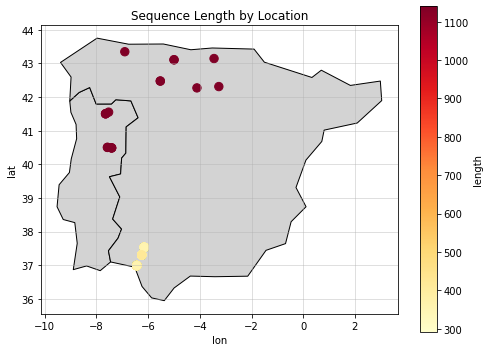

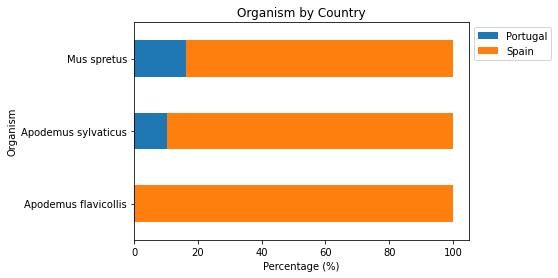

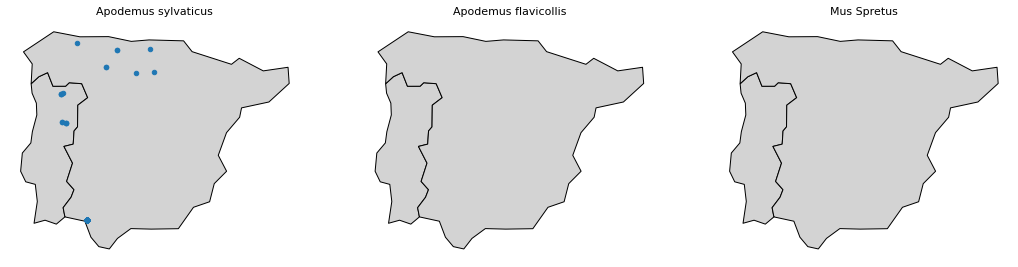

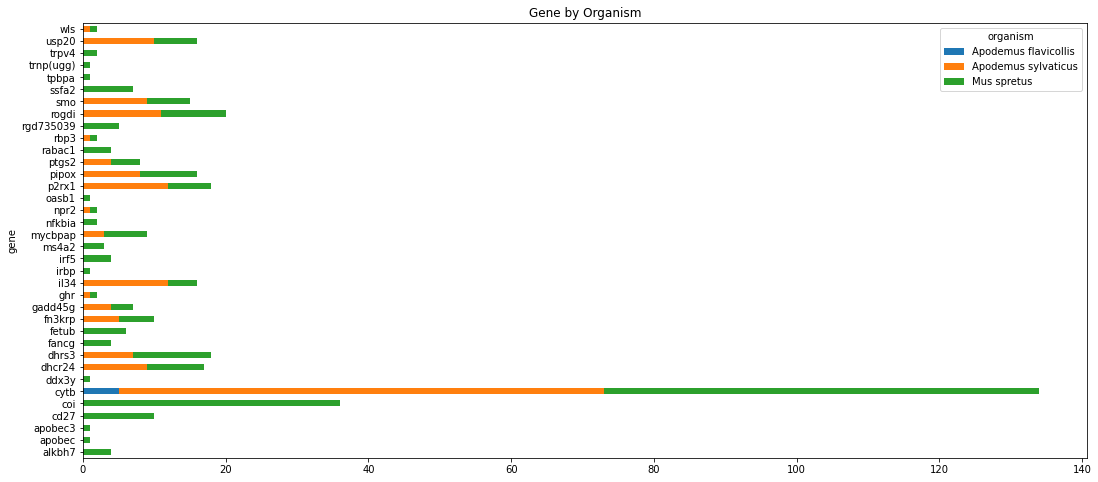

In [ ]:
# Definir metadatos
Entrez.email = 'gsaladocarr@alumni.unav.es'
db = 'nuccore'
Countries = ['Spain','Portugal']
Species = ['Apodemus sylvaticus', 'Apodemus flavicollis', 'Mus Spretus']

# Llamar a la función y guardar dataframe
filename = 'Results_Python.csv'
df = researcher(Species, db, Countries)
df.to_csv(filename, sep=';')

# Importar resultados
#filepath = r'/content/drive/MyDrive/'+filename
#df = pd.read_csv(filepath, index_col=0, sep=';')
#tab = data_table.DataTable(df, num_rows_per_page=10)
#tab

# Graficar resultados
import time
t = time.time()
plotter(df)
print('Tiempo para graficar: ', time.time() - t)


Text(0.5, 0, 'Count of ID')

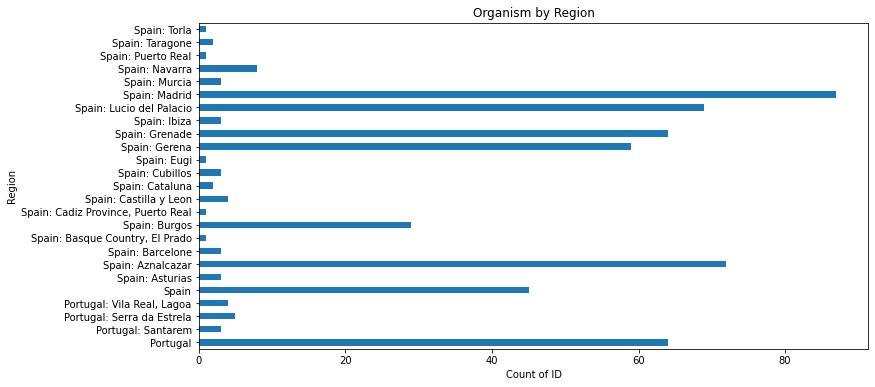

In [ ]:
filename = 'Regiones.csv' 
filepath = r'/content/' + filename

# Leer regiones con diferentes formatos 
df_region = pd.read_csv(filepath, index_col=0, sep=';')

# Grafica
len_region = df_region.groupby(["region"])["length"].count()
fig, ax4 = plt.subplots(figsize=(12,6))
len_region.plot(ax=ax4, kind='barh', stacked=True)
plt.title("Organismo por Region")
plt.ylabel("Region")
plt.xlabel("Cantidad de ID")